# Module 6: Explainable AI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NabKh/ML-for-Materials-Science/blob/main/Tutorial-07-ML-Discovery/notebooks/06_explainable_ai.ipynb)

---

## 🎯 Learning Objectives

1. **Understand** why model interpretability matters in materials science
2. **Calculate** SHAP values to explain predictions
3. **Visualize** feature importance globally and locally
4. **Extract** physical insights from ML models

---

**⏱️ Estimated time: 60 minutes** | **📚 Difficulty: 🟡🔴 Intermediate-Advanced**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory
os.makedirs('figures', exist_ok=True)

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# SHAP for explainability
try:
    import shap
    shap.initjs()
    HAS_SHAP = True
except:
    HAS_SHAP = False
    print("SHAP not installed. Install with: pip install shap")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

np.random.seed(42)
print("✅ Libraries loaded successfully!" if HAS_SHAP else "⚠️ SHAP not available")

✅ Libraries loaded successfully!


## 1. Why Explainability?

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #10b981;">

**In materials science, we don't just want predictions - we want understanding!**

- Which features drive band gap predictions?
- Why does the model predict this material is stable?
- Does the model learn physically meaningful patterns?

**SHAP (SHapley Additive exPlanations)** answers these questions using game theory.

</div>

### 📖 The Interpretability Spectrum

| Model Type | Interpretability | Examples |
|------------|------------------|----------|
| **White-box** | High (inherently interpretable) | Linear Regression, Decision Trees |
| **Gray-box** | Medium (some insight possible) | Random Forest, Gradient Boosting |
| **Black-box** | Low (requires external tools) | Neural Networks, Deep Learning |

### ❓ Key Questions This Module Answers

1. How much does each feature contribute to a specific prediction?
2. Which features are globally most important across all predictions?
3. How do feature values relate to their impact on predictions?
4. Can we validate that our model learns physically meaningful patterns?

In [2]:
# Create synthetic dataset with interpretable features
np.random.seed(42)
n = 500

# Meaningful feature names (like matminer)
feature_names = [
    'MeanElectronegativity', 'StdElectronegativity', 'MeanAtomicRadius',
    'MeanValenceElectrons', 'MeanMeltingPoint', 'StdMeltingPoint',
    'MaxElectronegativity', 'MinElectronegativity', 'RangeElectronegativity',
    'MeanCovalentRadius'
]

X = np.random.randn(n, len(feature_names))

# Band gap depends mainly on electronegativity features
y = (
    2.5 * X[:, 0] +          # MeanElectronegativity (strong)
    1.2 * X[:, 1]**2 +       # StdElectronegativity (quadratic)
    0.8 * X[:, 6] +          # MaxElectronegativity
    -0.5 * X[:, 3] +         # MeanValenceElectrons (negative)
    0.3 * np.random.randn(n) # Noise
)

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['band_gap'] = y

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_s, y_train)

print(f"Model R² on test set: {model.score(X_test_s, y_test):.4f}")

Model R² on test set: 0.9031


## 2. SHAP Values: The Mathematics

### 📖 Theory: From Game Theory to ML Explainability

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #6366f1;">

**SHAP values** are based on **Shapley values** from cooperative game theory (Lloyd Shapley, Nobel Prize 2012).

**Core Idea**: Fairly distribute the "payout" (prediction) among "players" (features).

</div>

### 🔢 The Shapley Value Formula

For a feature $i$, its Shapley value is:

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left[ f(S \cup \{i\}) - f(S) \right]$$

Where:
- $N$ = set of all features
- $S$ = subset of features not including $i$
- $f(S)$ = model prediction using only features in $S$
- $|S|!$ = factorial of the size of $S$

### 💡 Intuition

The formula considers **all possible orderings** of features:
1. Take a subset $S$ of features (without feature $i$)
2. Add feature $i$ to the subset
3. Measure the change in prediction: $f(S \cup \{i\}) - f(S)$
4. Average over all possible subsets

### Key Properties of SHAP Values

| Property | Description | Formula |
|----------|-------------|---------|
| **Efficiency** | SHAP values sum to the prediction difference | $\sum_{i=1}^{N} \phi_i = f(x) - E[f(x)]$ |
| **Symmetry** | Equal contribution → Equal SHAP value | If $f(S \cup \{i\}) = f(S \cup \{j\})$ for all $S$, then $\phi_i = \phi_j$ |
| **Dummy** | No contribution → Zero SHAP value | If $f(S \cup \{i\}) = f(S)$ for all $S$, then $\phi_i = 0$ |
| **Additivity** | SHAP values are additive across models | $\phi_i(f+g) = \phi_i(f) + \phi_i(g)$ |

In [3]:
if HAS_SHAP:
    # Create SHAP explainer
    explainer = shap.Explainer(model, X_train_s, feature_names=feature_names)
    
    # Calculate SHAP values for test set
    shap_values = explainer(X_test_s)
    
    print(f"SHAP values shape: {shap_values.values.shape}")
    print(f"  {len(X_test_s)} samples × {len(feature_names)} features")

SHAP values shape: (100, 10)
  100 samples × 10 features


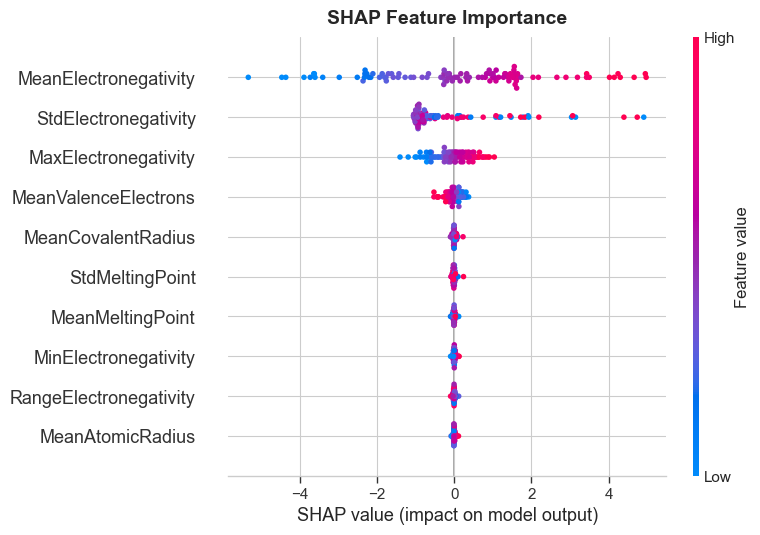

In [4]:
if HAS_SHAP:
    # SHAP Summary Plot - using SHAP's built-in beeswarm
    plt.figure(figsize=(10, 8))
    shap.plots.beeswarm(shap_values, show=False, max_display=10)
    plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig('figures/06_shap_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

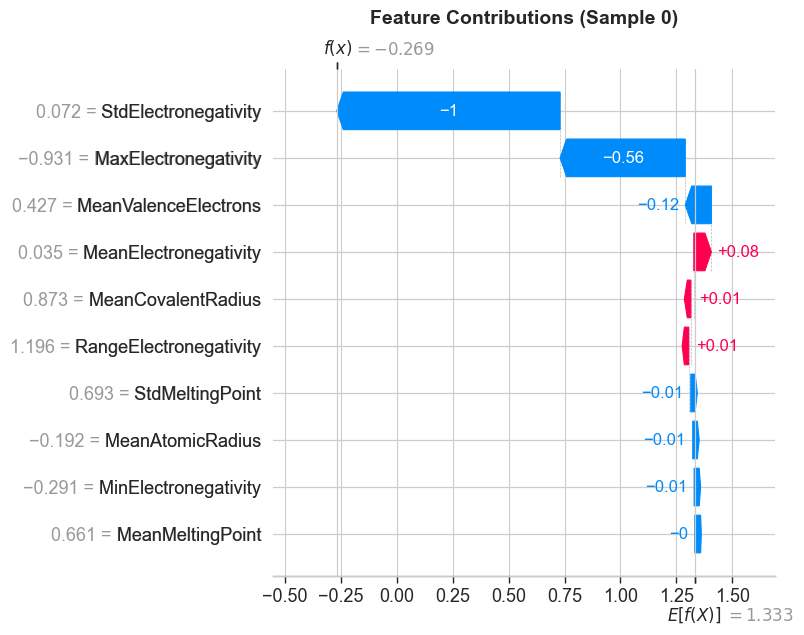

In [5]:
if HAS_SHAP:
    # SHAP Waterfall Plot - using SHAP's built-in waterfall
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_values[0], show=False, max_display=10)
    plt.title('Feature Contributions (Sample 0)', fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig('figures/06_shap_waterfall.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

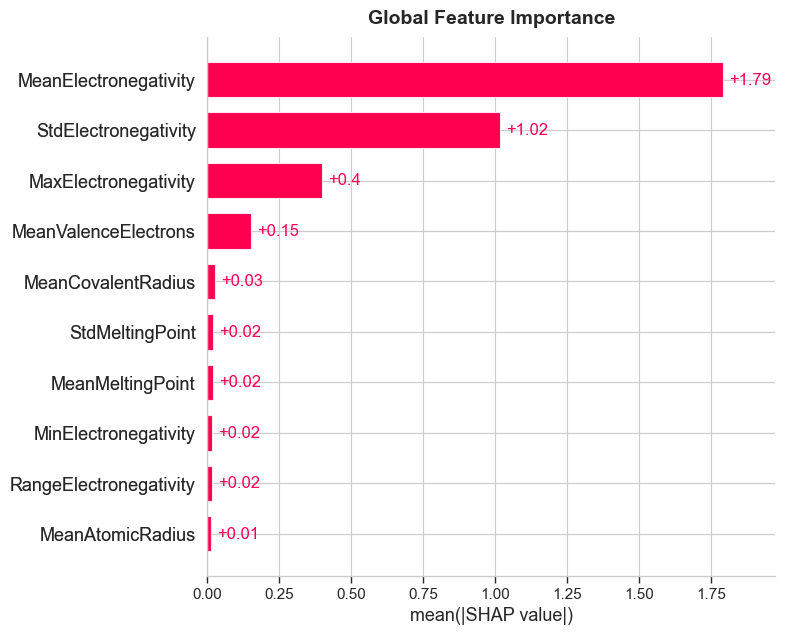

In [6]:
if HAS_SHAP:
    # SHAP Bar Plot - using SHAP's built-in bar
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, show=False, max_display=10)
    plt.title('Global Feature Importance', fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.savefig('figures/06_shap_bar.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

## 3. Physical Insights from SHAP

### 📖 Connecting ML to Materials Science

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #f59e0b;">

**The real power of SHAP**: Validating that our model learns physically meaningful relationships!

**For band gap prediction, we expect:**
- Higher electronegativity difference → Larger band gap (ionic bonding)
- More valence electrons → Smaller band gap (more metallic)
- Larger atomic radii → Smaller band gap (weaker bonding)

**SHAP dependence plots** reveal these relationships directly from the model.

</div>

### 🔢 Physical Relationships to Look For

| Feature | Expected Effect on Band Gap | Physical Reason |
|---------|----------------------------|-----------------|
| Electronegativity ↑ | Band gap ↑ | Stronger ionic character |
| Valence electrons ↑ | Band gap ↓ | More metallic behavior |
| Atomic radius ↑ | Band gap ↓ | Weaker orbital overlap |
| Electronegativity difference ↑ | Band gap ↑ | More charge transfer |

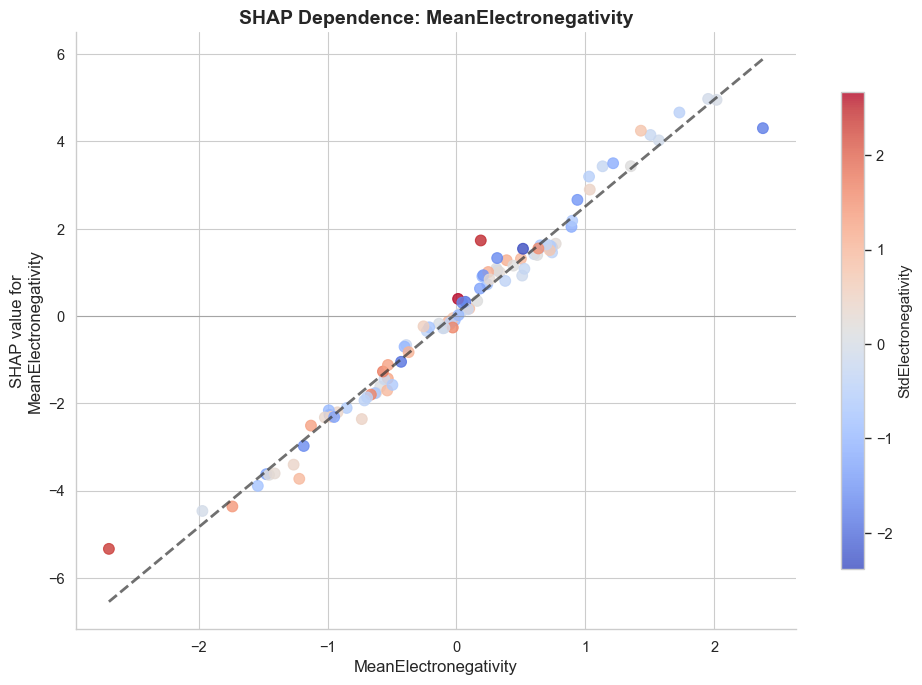

In [7]:
if HAS_SHAP:
    # SHAP Dependence Plot - clean version without histogram
    fig, ax = plt.subplots(figsize=(10, 7))
    
    x = X_test_s[:, 0]  # MeanElectronegativity
    y = shap_values.values[:, 0]
    c = X_test_s[:, 1]  # StdElectronegativity for color
    
    scatter = ax.scatter(x, y, c=c, cmap='coolwarm', s=60, alpha=0.8)
    
    # Trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), '--', color='#333', linewidth=2, alpha=0.7)
    
    ax.axhline(0, color='gray', linewidth=0.8, alpha=0.5)
    ax.set_xlabel('MeanElectronegativity', fontsize=12)
    ax.set_ylabel('SHAP value for\nMeanElectronegativity', fontsize=12)
    ax.set_title('SHAP Dependence: MeanElectronegativity', fontsize=14, fontweight='bold')
    
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('StdElectronegativity', fontsize=11)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('figures/06_shap_dependence.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

---

## 📝 Exercises

### 🎮 Quiz: Test Your Understanding

<div style="background: rgba(99, 102, 241, 0.1); padding: 15px; border-radius: 10px; border-left: 4px solid #6366f1;">

**Q1**: What does a positive SHAP value mean?
- A) The feature increases the prediction
- B) The feature decreases the prediction
- C) The feature has no effect
- D) The feature is not important

**Q2**: In a SHAP summary plot, what does the color of each dot represent?
- A) The SHAP value
- B) The feature value (high/low)
- C) The prediction error
- D) The sample index

**Q3**: Why is explainability important in materials science?
- A) To make prettier plots
- B) To validate models learn physical relationships
- C) To reduce computation time
- D) To increase model accuracy

</div>

### 💡 Quiz Answers
<details>
<summary>Click to reveal answers</summary>

**Q1**: A) The feature increases the prediction  
**Q2**: B) The feature value (high/low)  
**Q3**: B) To validate models learn physical relationships

</details>

---

### Exercise 1: Analyze Feature Interactions

Explore how different features affect the band gap prediction using SHAP dependence plots.

In [8]:
# Exercise 1: Create dependence plots for other features
# Which features show non-linear relationships?

# TODO: Uncomment and run to explore feature relationships
# if HAS_SHAP:
#     features_to_explore = ['StdElectronegativity', 'MaxElectronegativity', 'MeanValenceElectrons']
#     
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))
#     
#     for ax, feature in zip(axes, features_to_explore):
#         shap.dependence_plot(feature, shap_values.values, X_test_s, 
#                              feature_names=feature_names, show=False, ax=ax)
#         ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
#     
#     plt.tight_layout()
#     plt.savefig('figures/06_shap_dependence_multi.png', dpi=200, bbox_inches='tight')
#     plt.show()

# Questions to answer:
# 1. Which feature shows a LINEAR relationship with SHAP values?
# 2. Which feature shows a NON-LINEAR (quadratic) relationship?
# 3. Does MeanValenceElectrons have positive or negative effect on band gap?

print("Exercise 1: Analyze the dependence plots")
print("="*50)
print("Questions to answer:")
print("1. Which feature shows a LINEAR relationship?")
print("2. Which feature shows a NON-LINEAR relationship?")
print("3. What is the effect of MeanValenceElectrons?")

Exercise 1: Analyze the dependence plots
Questions to answer:
1. Which feature shows a LINEAR relationship?
2. Which feature shows a NON-LINEAR relationship?
3. What is the effect of MeanValenceElectrons?


---

## 4. Other Explainability Methods

### 📖 Beyond SHAP: A Comparison

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #ec4899;">

| Method | Type | Pros | Cons |
|--------|------|------|------|
| **SHAP** | Model-agnostic | Theoretically grounded, consistent | Computationally expensive |
| **LIME** | Model-agnostic | Fast, intuitive | Less consistent |
| **Permutation Importance** | Model-agnostic | Simple to understand | Doesn't show direction |
| **Integrated Gradients** | Deep Learning | Works with neural nets | Only for differentiable models |
| **Attention Weights** | Transformers | Built-in interpretation | May not reflect true importance |

</div>

### 🔢 Permutation Importance Formula

$$\text{Importance}_i = \text{Score}_{\text{original}} - \text{Score}_{\text{permuted}_i}$$

Where $\text{Score}_{\text{permuted}_i}$ is the model score after randomly shuffling feature $i$.

---

## ✅ Module Summary

### Key Takeaways

<div style="background: rgba(16, 185, 129, 0.1); padding: 15px; border-radius: 10px; border-left: 4px solid #10b981;">

1. **SHAP values** use game theory to fairly attribute predictions to features
2. **Summary plots** show global feature importance with directional effects
3. **Waterfall plots** break down individual predictions step-by-step
4. **Dependence plots** reveal feature-target relationships (linear, non-linear)
5. **Physical validation**: SHAP helps confirm models learn meaningful chemistry!

</div>

### 🔢 Key Formulas to Remember

| Formula | Description |
|---------|-------------|
| $\phi_i = \sum_{S} \frac{|S|!(n-|S|-1)!}{n!}[f(S \cup \{i\}) - f(S)]$ | Shapley value for feature $i$ |
| $\sum_{i=1}^{n} \phi_i = f(x) - E[f(x)]$ | SHAP values sum to prediction deviation |
| $\text{mean}(|\phi_i|)$ | Global feature importance |

### 🎯 Best Practices

1. **Always validate** SHAP insights against domain knowledge
2. **Use multiple samples** for waterfall plots to avoid cherry-picking
3. **Check for interactions** using dependence plots with color
4. **Compare methods** (SHAP vs permutation importance) for robustness

---

**📚 Continue to Module 7:** [Project: Band Gap Prediction](07_project_bandgap.ipynb)